<a href="https://colab.research.google.com/github/nuneslg/LSTMforBitcoin/blob/main/Mini_ProjetoLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Projeto com LSTMs - IF702 Redes Neurais

## LSTM para prever a cotação (fechamento) do Bitcoin de 2017 a 2023

- Usar primeiros 80% dos registros para treinamento;
- Restante 20% mais recentes para teste;
- Usar o arquivo de dados em anexo nesta atividade (cotações de 2017 a 2023);
- Prever apenas o preço de fechamento;
- Usar, inicialmente, apenas a série com os valores de fechamento para
treinar e testar o modelo;
- Em um segundo momento pode-se verificar se as outras variáveis do arquivo melhoram o desempenho;
- Atenção: apenas os dados até o dia atual devem ser usados para prever o dia seguinte (ex: valor de abertura do dia seguinte não deve ser usado para
prever o fechamento daquele dia);
- Pesquisar hiperparâmetros que podem ser variados (importante: um deles é o tamanho da janela).

## Drive

Pasta compartilhada entre os membros para registro de experimentos e análise final

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configurações

In [2]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

## Processamento dos Dados

In [3]:
url = 'https://drive.google.com/uc?id=1BUjDNoShYAfQ6aH5GRvh6duO94TTxsil'
btc = pd.read_csv(url)

btc.head()


,date,open,high,low,close,number_of_trades
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,3427
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,5233
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,2153
3,2017-08-20,4139.98,4211.08,4032.62,4086.29,2321
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,3972


In [4]:
# Utilizando inicialmente apenas os valores de fechamento
data_to_use=btc['close'].values
data_to_use

array([ 4285.08,  4108.37,  4139.98, ..., 29281.09, 29232.25, 28902.49])

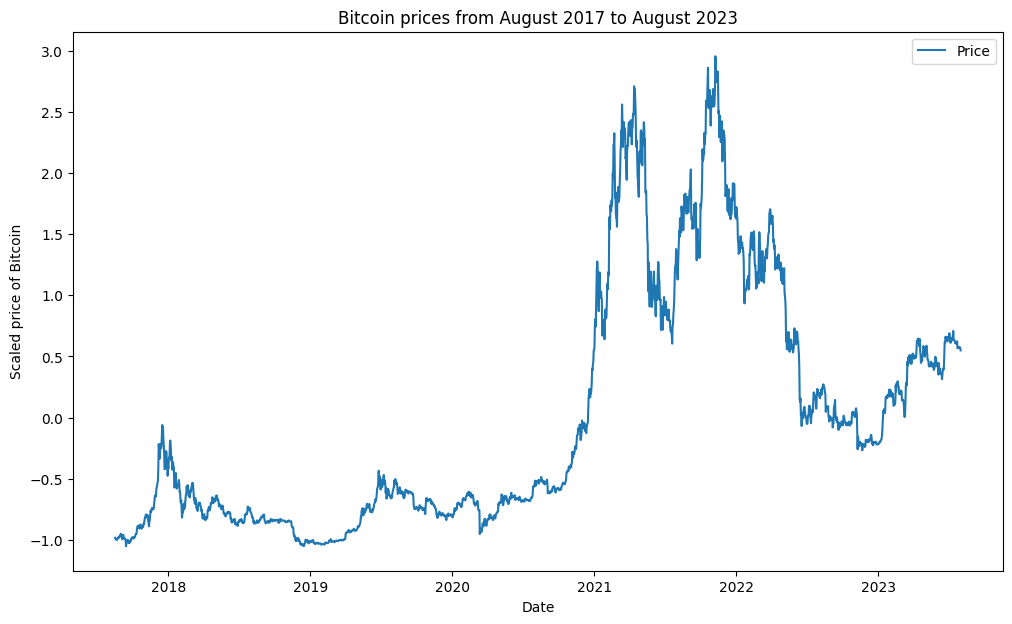

In [5]:
btc['date'] = pd.to_datetime(btc['date'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

# Plotando os dados
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from August 2017 to August 2023')
plt.xlabel('Date')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(btc['date'], scaled_data, label='Price')
plt.legend()
plt.show()


## Janela de Dados

In [6]:
# Adaptado de: https://github.com/brianmwangy/predicting-bitcoin-prices-using-LSTM
# Autor: Brian Mwangi

# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

window_size = 3

def window_data(data, window_size):
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, window_size)


#we now split the data into training and test set
split_idx = int(len(X) * 0.8) # 80% treino e 20% teste

X_train = np.array(X[:split_idx])  # Janela de treino: só dados antigos
y_train = np.array(y[:split_idx])

X_test = np.array(X[split_idx:])   # Janela de teste: dados mais recentes
y_test = np.array(y[split_idx:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1738, 3, 1)
y_train size: (1738, 1)
X_test size: (435, 3, 1)
y_test size: (435, 1)


## Modelo

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

# Hiperparâmetros
window_size = 3  # Ao alterar é necessário alterar também na função window_data
hidden_layer = 256
learning_rate = 0.001
epochs = 300
batch_size = 4
dropout = 0.001


model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(hidden_layer, dropout=dropout),
    Dense(1)
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error')

## Treinamento

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

patience = 40
min_delta = 0.00005

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta, restore_best_weights=True)

In [9]:
history = model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping]) # only uses test data

Epoch 1/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1277 - val_loss: 0.0066
Epoch 2/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0106 - val_loss: 0.0036
Epoch 3/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0098 - val_loss: 0.0049
Epoch 4/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0089 - val_loss: 0.0039
Epoch 5/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0087 - val_loss: 0.0034
Epoch 6/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0080 - val_loss: 0.0038
Epoch 7/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0088 - val_loss: 0.0030
Epoch 8/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0078 - val_loss: 0.0032
Epoch 9/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 10/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 11/300
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0335 - val_loss: 0.0023
Epoch 12/300
435/435 ━━━━━━━━━

## Avaliação

### Loss

In [10]:
import numpy as np

def calc_pocid(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calcula a direção (diferença entre t e t-1)
    real_diff = np.sign(y_true[1:] - y_true[:-1])
    pred_diff = np.sign(y_pred[1:] - y_pred[:-1])

    # Conta acertos de direção
    correct_direction = (real_diff == pred_diff)
    pocid = np.sum(correct_direction) / len(correct_direction) * 100

    return pocid


In [11]:
y_pred_test = model.predict(X_test)
pocid = calc_pocid(y_test, y_pred_test)
print(f"POCID: {pocid:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
POCID: 46.77%


In [12]:
# MSE
test_loss = model.evaluate(X_test, y_test)
print("Loss no teste:", test_loss)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Loss no teste: 0.0017277628649026155
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [13]:
# RMSE
rmse = np.sqrt(test_loss)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.04156636699186754


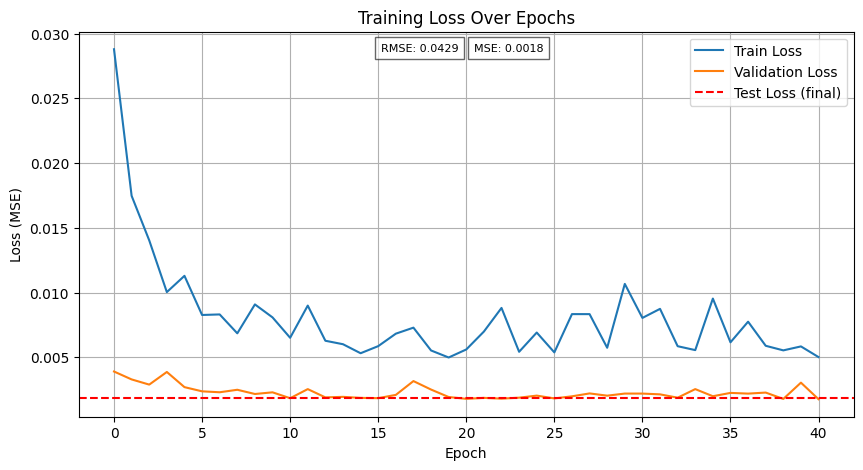

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss (final)')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.text(0.39, 0.95, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes,
         fontsize=8, bbox=dict(facecolor='white', alpha=0.6))
plt.text(0.51, 0.95, f'MSE: {test_loss:.4f}', transform=plt.gca().transAxes,
         fontsize=8, bbox=dict(facecolor='white', alpha=0.6))
plt.grid(True)
plt.show()

In [71]:
print(history.history['loss'])

[0.11261165887117386, 0.10652019828557968, 0.08490137755870819, 0.10188915580511093, 0.1269407868385315, 0.11612480133771896, 0.08470025658607483, 0.126163050532341, 0.09850338846445084, 0.11254602670669556, 0.10057345777750015, 0.0876217857003212, 0.09102404117584229, 0.09721993654966354, 0.09742892533540726, 0.1277414709329605, 0.10300745815038681, 0.117740198969841, 0.08852265030145645, 0.09058047831058502, 0.10112061351537704, 0.07660473138093948, 0.10784555226564407, 0.10151149332523346, 0.13510456681251526, 0.08875864744186401, 0.124647356569767, 0.091048963367939, 0.08920130878686905, 0.09125397354364395, 0.08993043005466461, 0.08754408359527588, 0.10567541420459747, 0.08458065241575241, 0.0833805650472641, 0.10257766395807266, 0.10214611142873764, 0.11826527863740921, 0.09710760414600372, 0.09521757811307907, 0.10946457833051682, 0.09423019737005234, 0.11252356320619583, 0.10421482473611832, 0.0876019224524498, 0.10318212956190109, 0.12210714817047119, 0.09859417378902435, 0.08

In [72]:
print(history.history['val_loss'])

[0.004310287069529295, 0.026967570185661316, 0.005866075400263071, 0.0034578959457576275, 0.006169949658215046, 0.00762789323925972, 0.002182614291086793, 0.0032440265640616417, 0.002120662247762084, 0.0030230004340410233, 0.0023414145689457655, 0.002369905123487115, 0.002584026660770178, 0.0036961794830858707, 0.011178819462656975, 0.002107835141941905, 0.004213142674416304, 0.0028454773128032684, 0.0019677220843732357, 0.0020827329717576504, 0.006046868860721588, 0.0027124567423015833, 0.0031917556189000607, 0.0026467328425496817, 0.0024515886325389147, 0.002419429598376155, 0.0020727093797177076, 0.0020270408131182194, 0.017297696322202682, 0.002044475171715021, 0.007115133106708527, 0.021611759439110756, 0.017069347202777863, 0.017008095979690552, 0.008915663696825504, 0.0063753812573850155, 0.006591726094484329, 0.0041068498976528645, 0.0028447553049772978, 0.0023686280474066734, 0.0022582823876291513, 0.0054875751957297325, 0.005285671446472406, 0.0025417886208742857, 0.002870566

### Predições de Preço

In [169]:
# Inicialmente vazios e começam a ser preenchidos após o tamanho da janela

train_results = np.empty_like(scaled_data)
train_results[:] = np.nan

test_results = np.empty_like(scaled_data)
test_results[:] = np.nan

# Resultados a partir de window size
train_results[window_size:window_size + len(y_pred_train)] = y_pred_train.reshape(-1, 1)

# Resultados de teste após resultados de treino
test_start = window_size + len(y_pred_train)
test_results[test_start:test_start + len(y_pred_test)] = y_pred_test.reshape(-1, 1)

In [170]:
# Desnormaliza os valores para o plot
original_real_scale = scaler.inverse_transform(scaled_data)
train_results_real_scale = scaler.inverse_transform(train_results)
test_results_real_scale = scaler.inverse_transform(test_results)

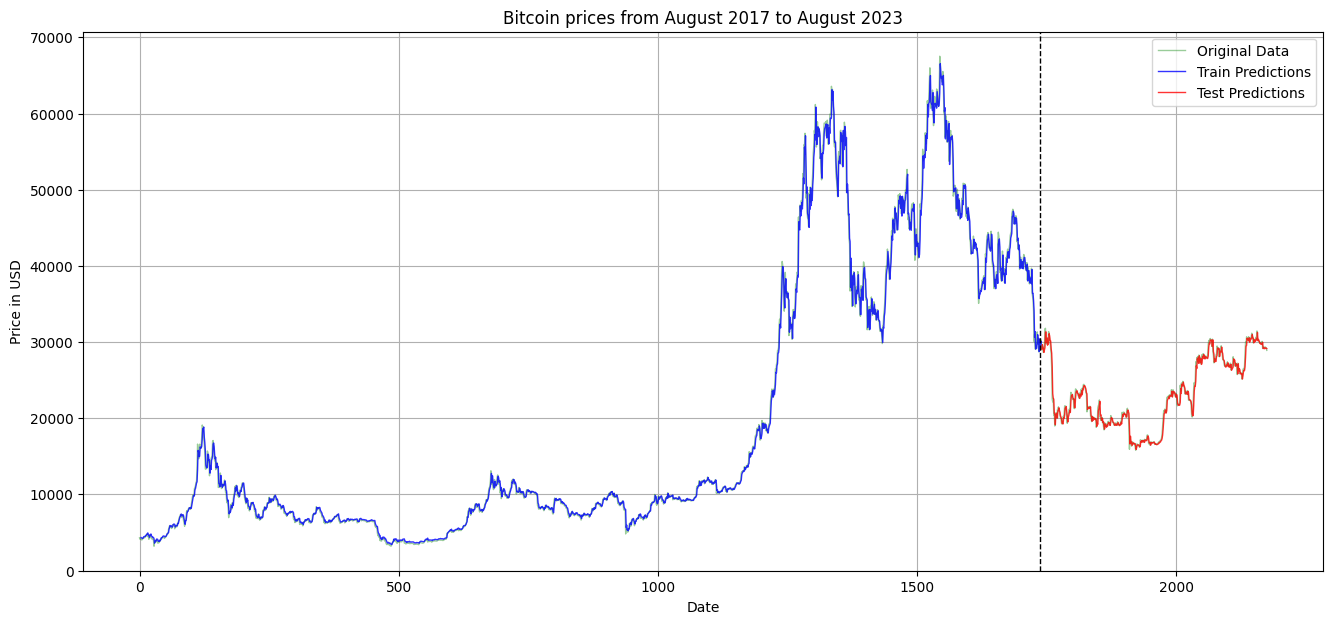

In [171]:
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from August 2017 to August 2023')
plt.xlabel('Date')
plt.ylabel('Price in USD')

plt.plot(original_real_scale, label='Original Data', color='green', linewidth=1, alpha=0.4)
plt.plot(train_results_real_scale, label='Train Predictions', color='blue', linewidth=1, alpha=0.8)
plt.plot(test_results_real_scale, label='Test Predictions', color='red', linewidth=1, alpha=0.8)
plt.axvline(x=split_idx, color='black', linestyle='--', linewidth=1)

plt.grid(True)
plt.legend()
plt.show()

## Carregar Experimento

In [172]:
train_loss_final = history.history['loss'][-1]
val_loss_final = history.history['val_loss'][-1]
epochs_final = len(history.history['loss'])


In [173]:
df_novo = pd.DataFrame({
  'hidden_layer': [hidden_layer],
  'window_size': [window_size],
  'batch_size': [batch_size],
  'learning_rate': [float(learning_rate)],
  'total_epochs': [epochs],
  'test_loss': [float(test_loss)],
  'train_loss': [float(train_loss_final)],
  'val_loss': [float(val_loss_final)],
  'rmse': [float(rmse)],
  'dropout': [float(dropout)],
  'patience' : [patience],
  'min_delta' : [min_delta],
  'trained_epochs' : [epochs_final]
})


In [174]:
import os

file_path = '/content/drive/MyDrive/ProjetoLSTM/experimentos.csv'

if os.path.exists(file_path):
    df_existente = pd.read_csv(file_path)

    # Junta as colunas que faltam em qualquer um dos dois
    df_todos = pd.concat([df_existente, df_novo], ignore_index=True, sort=False)

    # Salva sobrescrevendo, com todas as colunas
    df_todos.to_csv(file_path, index=False)
else:
    # Primeira vez: só salva o novo
    df_novo.to_csv(file_path, index=False)

print(f'Dados atualizados em: {file_path}')

Dados atualizados em: /content/drive/MyDrive/ProjetoLSTM/experimentos.csv


## Análise dos Experimentos

In [242]:
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/ProjetoLSTM/experimentos.csv')

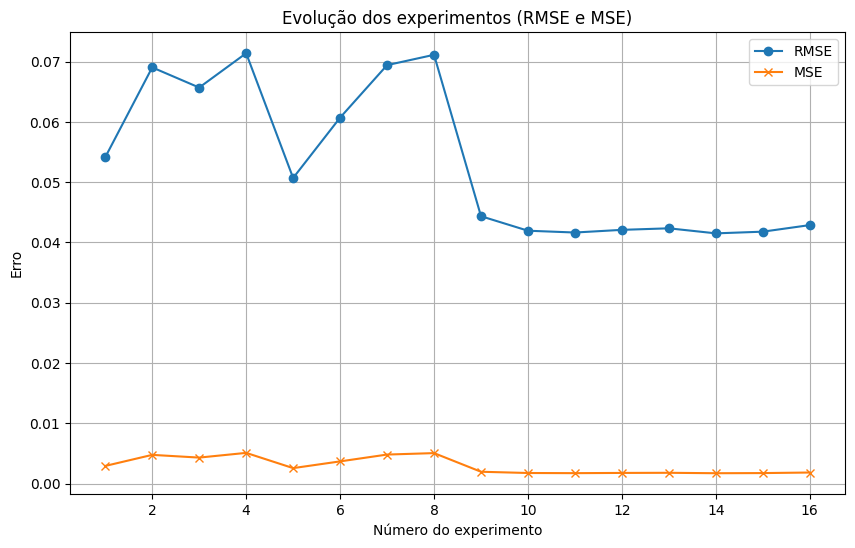

In [243]:
df['experimento'] = range(1, len(df) + 1)

plt.figure(figsize=(10, 6))
plt.plot(df['experimento'], df['rmse'], marker='o', label='RMSE')
plt.plot(df['experimento'], df['test_loss'], marker='x', label='MSE')
plt.xlabel("Número do experimento")
plt.ylabel("Erro")
plt.title("Evolução dos experimentos (RMSE e MSE)")
plt.legend()
plt.grid(True)
plt.show()

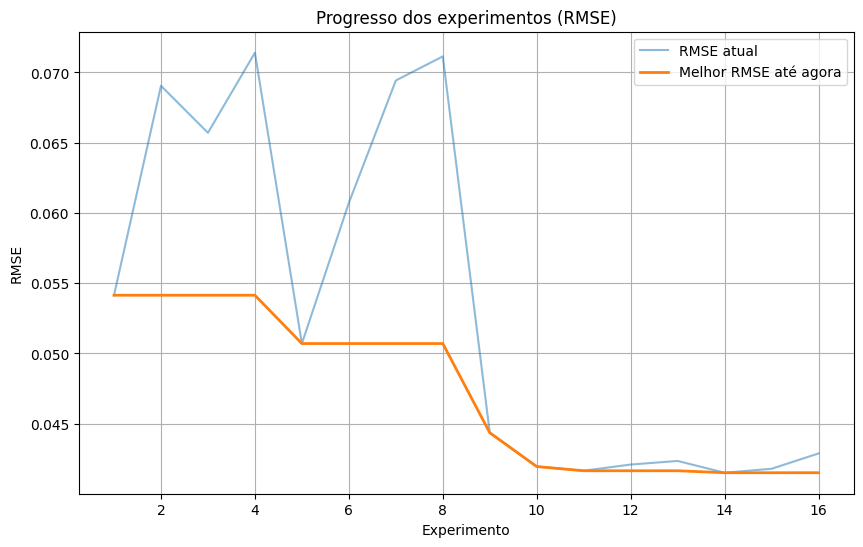

In [244]:
df['min_rmse_so_far'] = df['rmse'].cummin()

plt.figure(figsize=(10, 6))
plt.plot(df['experimento'], df['rmse'], label='RMSE atual', alpha=0.5)
plt.plot(df['experimento'], df['min_rmse_so_far'], label='Melhor RMSE até agora', linewidth=2)
plt.xlabel("Experimento")
plt.ylabel("RMSE")
plt.title("Progresso dos experimentos (RMSE)")
plt.legend()
plt.grid(True)
plt.show()


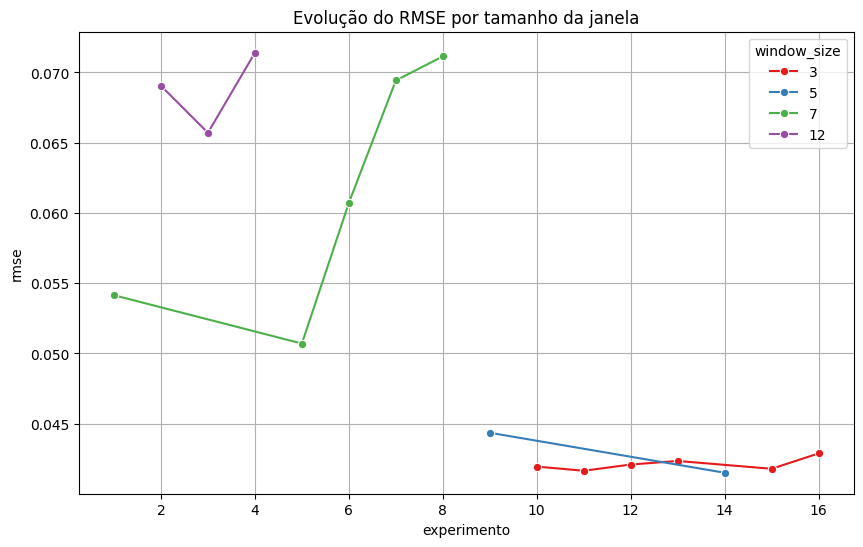

In [252]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='experimento', y='rmse', hue='window_size', marker='o', palette='Set1')
plt.title("Evolução do RMSE por tamanho da janela")
plt.grid(True)
plt.show()

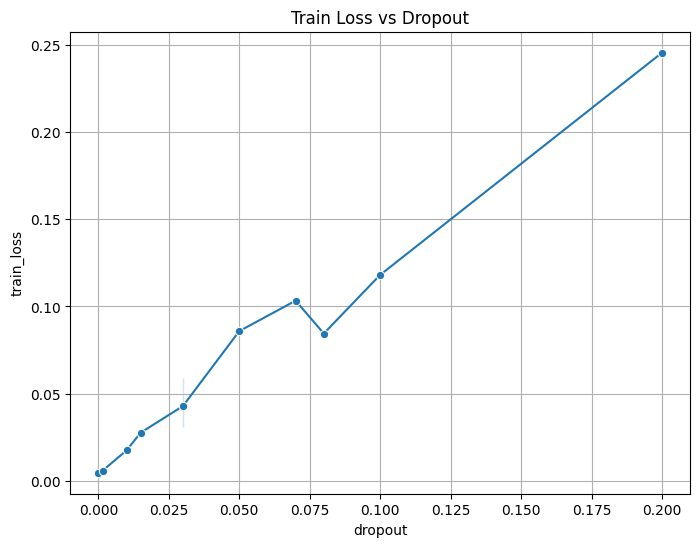

In [214]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df.sort_values('dropout'), x='dropout', y='train_loss', marker='o')
plt.title('Train Loss vs Dropout')
plt.grid(True)
plt.show()


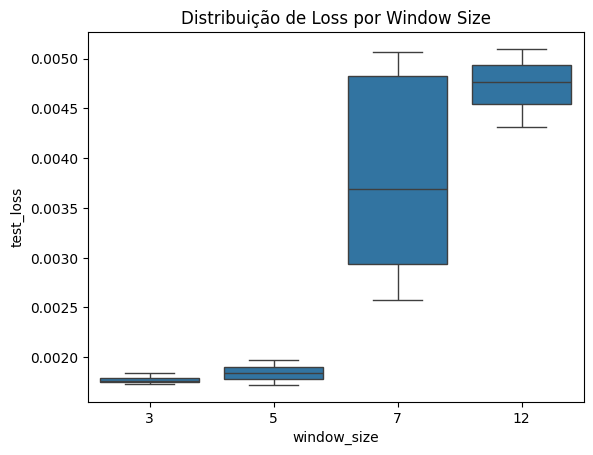

In [235]:
# Test loss por window_size
sns.boxplot(data=df, x='window_size', y='test_loss')
plt.title("Distribuição de Loss por Window Size")
plt.show()

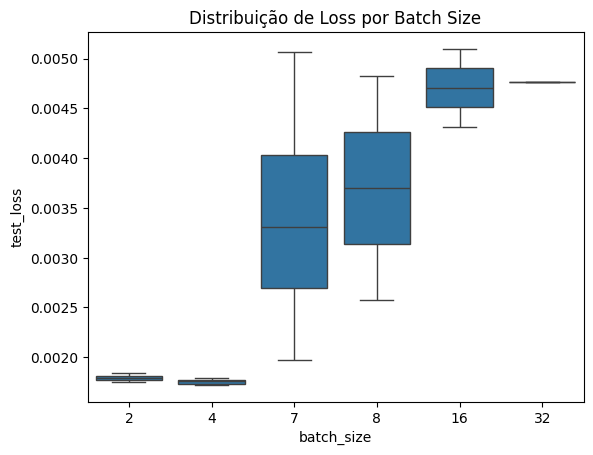

In [236]:
# Test loss por window_size
sns.boxplot(data=df, x='batch_size', y='test_loss')
plt.title("Distribuição de Loss por Batch Size")
plt.show()

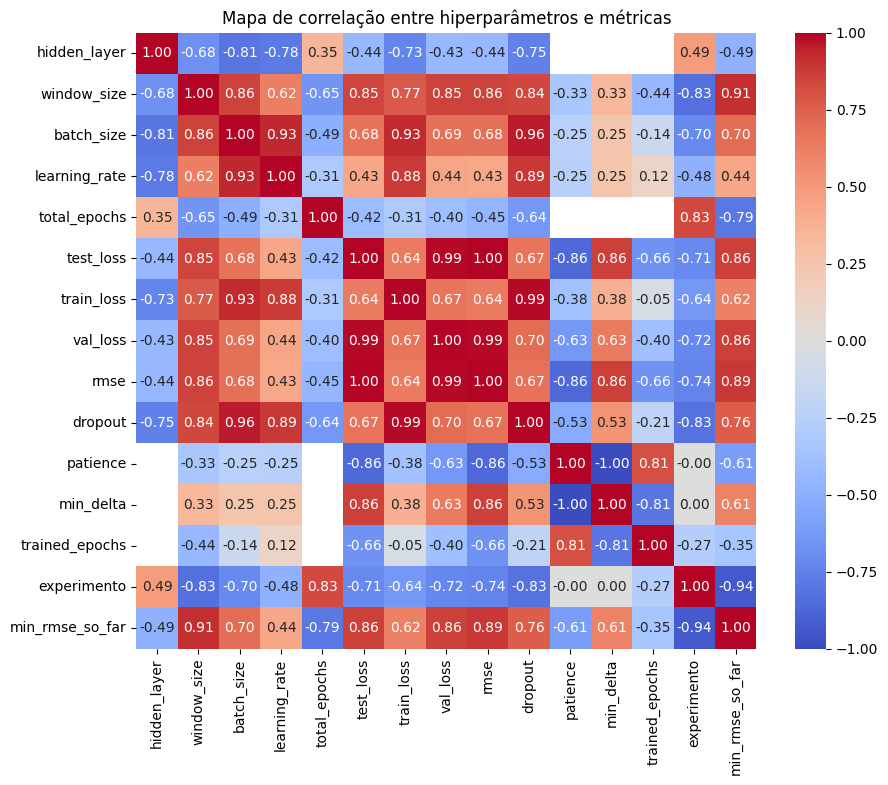

In [237]:
# Apenas experimentos com early stopping
df_com_es = df.iloc[8:].copy()



plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de correlação entre hiperparâmetros e métricas")
plt.show()


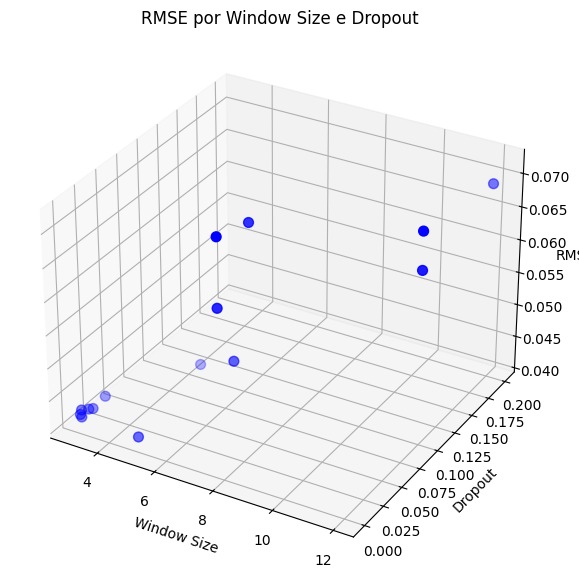

In [223]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['window_size'], df['dropout'], df['rmse'], c='blue', s=50)
ax.set_xlabel('Window Size')
ax.set_ylabel('Dropout')
ax.set_zlabel('RMSE')
ax.set_title('RMSE por Window Size e Dropout')
plt.show()


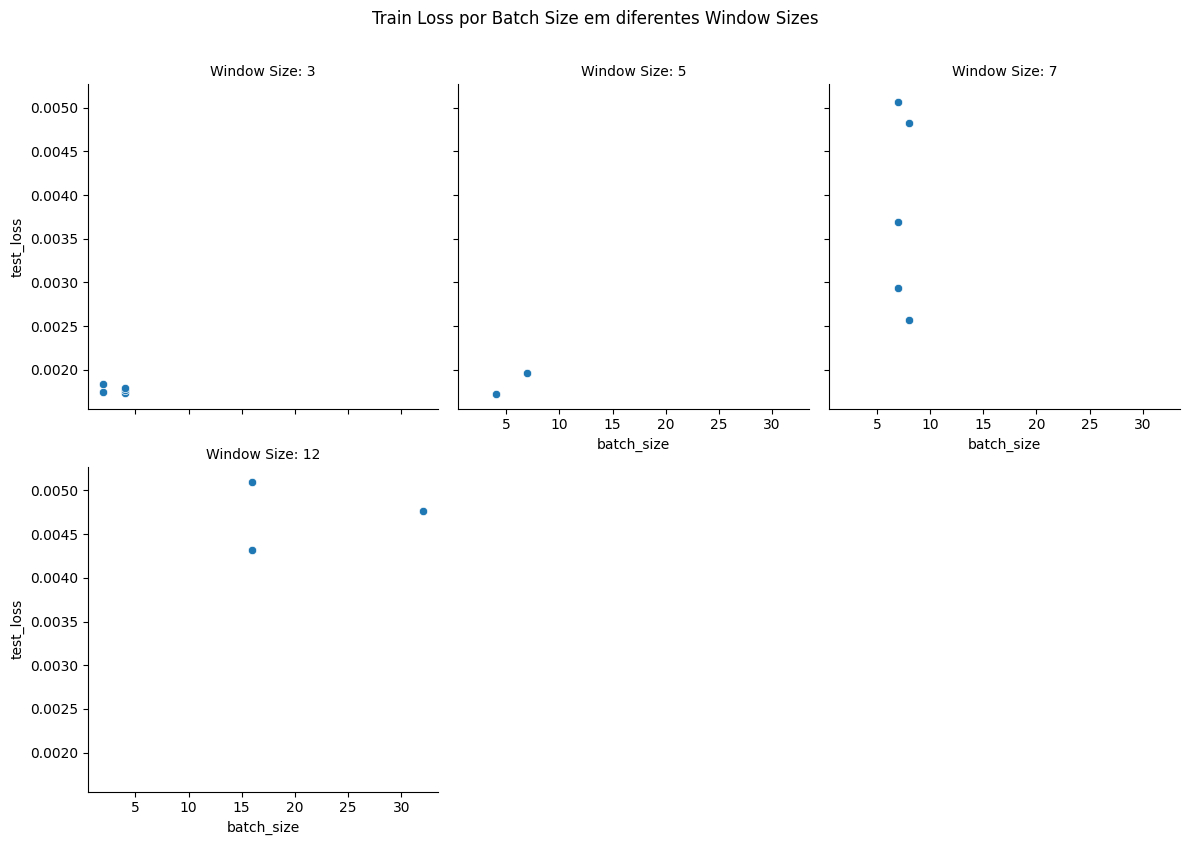

In [225]:
g = sns.FacetGrid(df, col="window_size", col_wrap=3, height=4)
g.map_dataframe(sns.scatterplot, x="batch_size", y="test_loss")
g.set_titles("Window Size: {col_name}")
g.fig.suptitle("Train Loss por Batch Size em diferentes Window Sizes", y=1.05)
plt.show()